# Random Forest Interpretation

WNixalo 2018/5/13-14

Codealong of [fast.ai ML1 L3](https://youtu.be/YSFG_W8JxBo): [notebook](https://github.com/fastai/fastai/blob/master/courses/ml1/lesson2-rf_interpretation.ipynb)

---

> [lecture 00:01:33](https://youtu.be/YSFG_W8JxBo?t=93) Random forests allow us to understand our data deeper and more quickly than traditional approaches.

Q: "when should we use Random Forests?"

A: "the question is more: *when should I use other things as well?"

> for Unstructured Data (sound waveform, words in text, pixels in images) I'll almost certainly want to try Deep Learning. For Collaborative Filtering, neither DL nor RF are exactly what you want (tweaks are needed)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [3]:
set_plot_sizes(12,14,16)

## 1.1 Load in our data from last lesson

[Lecture 3 - 51:07](https://youtu.be/YSFG_W8JxBo?t=3067)

We already read in our CSV and processed it into categories in the Lesson 1 notebook. `proc_df` turns the categories into integers, deals w/ missing values, and pulls out the dependant variable (`y_trn`).

[Lecture 3 – 52:59](https://youtu.be/YSFG_W8JxBo?t=3179) Note on `proc_df`, `nas`, and `na_dict`:

> `proc_df` returns a dictionary telling you which columns were missing (had missing things?), and for each of those columns what the median was. When you call `proc_df` on the larger non-subset dataset you don't pass in `na_dict` as an argument – you just want to get back the result.

> Later on, when you pass it into a subset, you want to have the same missing columns and the same medians so you pass in `na_dict`. If the different subset (for example a different dataset) had different missing columns, `proc_df` would update the `na_dict` argument with additional p-values.

> If you don't pass it in, `proc_df` just gives you the information about what was missing & the medians. If you do pass it in it uses that information for any missing columns that are there – and if there are *new* missing columns it'll update the dictionary with that additional information.

> It keeps track of any missing columns you came across in anything you passed to `proc_df`.

In [4]:
PATH = 'data/bulldozers/'

df_raw = pd.read_feather('tmp/bulldozers-raw.feather')
df_trn, y_trn , nas = proc_df(df_raw, 'SalePrice')

In [5]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn) - n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [6]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())
def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid), 
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [7]:
df_raw # after proc_df. shows log(SalePrice)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,0,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,0,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,1,S175,...,23,3,204,False,False,False,False,False,False,1248307200
5,1139255,10.184900,1001274,4605,121,3.0,2004,508.0,2,310G,...,18,3,353,False,False,False,False,False,False,1229558400
6,1139256,9.952278,772701,1937,121,3.0,1993,11540.0,0,790ELC,...,26,3,239,False,False,False,False,False,False,1093478400
7,1139261,10.203592,902002,3539,121,3.0,2001,4883.0,0,416D,...,17,3,321,False,False,False,False,False,False,1132185600
8,1139272,9.975808,1036251,36003,121,3.0,2008,302.0,2,430HAG,...,27,3,239,False,False,False,False,False,False,1251331200
9,1139275,11.082143,1016474,3883,121,3.0,1000,20700.0,1,988B,...,9,3,221,False,False,False,False,False,False,1186617600


## 2. Confidence-based on tree variance


[Lecture 3 - 54:54](https://youtu.be/YSFG_W8JxBo?t=3294)

> We'd be less confident of a prediction if we hadn't seen many of rows like a particular row. And if we hadn't: we wouldn't expect any of the trees to have a path through which is designed to help us predict that row.

> So conceptually you'd expect that as you pass this unusual row through different trees it's going to end up in very different places.

> IoW: instead of taking the mean of the predictions of the trees and saying 'that's our prediction' – *what if we took the Standard Deviation* of the predictions of the trees.

> If the **Standard Deviation** of the preds of the trees is **high**: each tree is giving us a very different estimate of this row's prediction. So if this was a very common kind of row: the trees would've learnt to make good predictions for it bc they'd've seen lots of opportunities to split on those kinds of rows.

> *The Standard Deviation of the predictions across the trees gives us some kind of relative understanding of how confident we are of this prediction*.

> This doesn't exist in scikit-learn or other libraries so we'll have to create it.

For model interpretation, there's no need to use the full dataset on each tree – using a subset will be both faster, and also provide better interpretability (since an overfit model won't provide much variance across trees).

> We don't need a massively accurate RF, we just need one that indicates the nature of the relationships involved.

So you want `n_samples` to be high enough st if you call the same interpretation commands multiple times you don't get different results back each time.

In [8]:
set_rf_samples(50000)

In [9]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20550240018943106, 0.24727510802206912, 0.9117390447817355, 0.8908034859072879, 0.8948049439153177]


`preds`: **rows**: results of each tree. **cols**: result of each row in original dataset. (ie: trees x dataset_rows)

We can check out the mean and standard-deviation of the first column in `preds` – which is the μ&σ of our dataset's 1st row.

In [10]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.48 s, sys: 52 ms, total: 1.53 s
Wall time: 1.54 s


(9.3354467948131, 0.30467757743942037)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up. Fast AI provides the function `parallel_trees` which takes the random-forest model you trained, and some function to call – and calls that function on every tree in parallel.

In [11]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 117 ms, sys: 97 ms, total: 214 ms
Wall time: 1.03 s


(9.3354467948131, 0.30467757743942037)

(When CPU time roughly equals Wall time: that's 1 CPU working on it's own)

We can see that different trees are giving different estimates in this auction. In order to see how prediction confidence varies, we can add this to our dataset. "`Enclosure`" is one of the categories of our dataset, and has several subcategories:

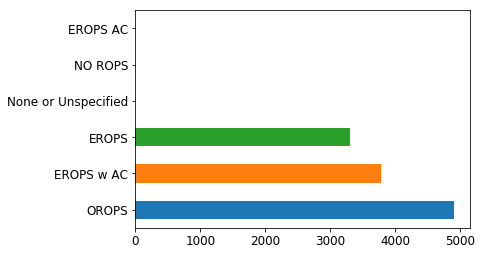

In [12]:
x = raw_valid.copy()                  # create copy of data
x['pred_std'] = np.std(preds, axis=0) # add col for stdv of preds
x['pred'] = np.mean(preds, axis=0)    # add col for mean of preds
x.Enclosure.value_counts().plot.barh();

We don't care about the 1st 3 subcategories because they never show up in the data.

We take our dataset and group it by 'Enclosure' and take the average of the 3 fields 'SalePrice', 'pred', & 'pred_std':

In [13]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.839894,0.270817
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.577495,0.261123
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.688541,0.224662


We can already get some insight. As you'd expect the sale price & prediction are close to each other on average – that's a good sign.

The Standard Deviation varies a little bit – to see it better we can plot it:

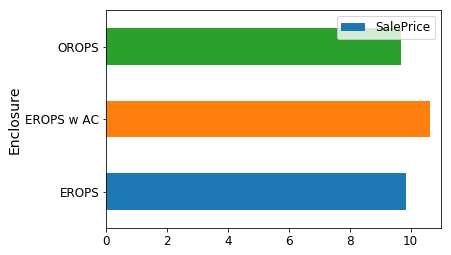

In [14]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

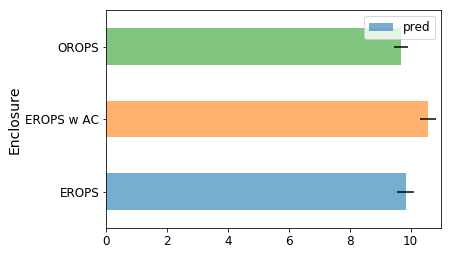

In [15]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

The error bars are the standard deviation of the prediction.

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

Doing the same thing for Product Size:

***why is matplotlib all of a sudden tasting the rainbow?..***

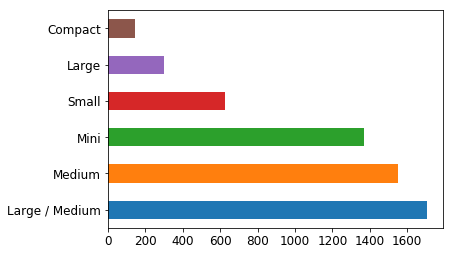

In [16]:
raw_valid.ProductSize.value_counts().plot.barh();

In [17]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.872288,0.330976
Large,10.470589,10.394293,0.354021
Large / Medium,10.691871,10.652369,0.290579
Medium,10.681511,10.625052,0.280709
Mini,9.535147,9.557366,0.247063
Small,10.324448,10.310762,0.309695


> we could ask "what's the ratio to the stdev of the predictions to the predictions themselves?" – you'd kinda expect on average that when you're predicting something that's a bigger number that you're standard deviation would be higher. So you can sort by that number

> What this tell us is our "Large" and "Compact" Product Sizes are less accurate (relatively speaking as a ratio of the total price):

In [18]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Large             0.034059
Compact           0.033526
Small             0.030036
Large / Medium    0.027278
Medium            0.026420
Mini              0.025850
dtype: float64

If you go back to the histogram above you'll see 'Large' and 'Compact' are the smallest groups – so of course. You always want to see the confidence intervals for deployed models.

## 3. Feature Importance

[Lecture 3 – 1:07:20](https://youtu.be/YSFG_W8JxBo?t=4040)

It's not normally enough to just know that a model can make accurate predictions – we also want to know *how* it's making predictions. The most important way to see this is with **feature importance**.

> We showed Confidence Intervals first because the intuition of how to calculate them is easier and similar to what we've already done. When it comes to which one do I look at first in practice: *I always look at * ***Feature Importance*** *in practice.*

> When I'm work on a Kaggle competition or a real-world project, I build a Random Forest as fast as I can – trying to get to the point it's significantly better than random (but doesn't need to be much better than that) – and the next thing I do is plot the feature importance.

> Feature Importance tells us: "in this Random Forest, which columns matter"

In [19]:
fi = rf_feat_importance(m, df_trn); fi[:10] # view top-10

,cols,imp
5,YearMade,0.174785
13,ProductSize,0.088344
37,Coupler_System,0.087752
14,fiProductClassDesc,0.081937
39,Hydraulics_Flow,0.077173
2,ModelID,0.062335
63,saleElapsed,0.051469
10,fiSecondaryDesc,0.042881
8,fiModelDesc,0.032704
38,Grouser_Tracks,0.030734


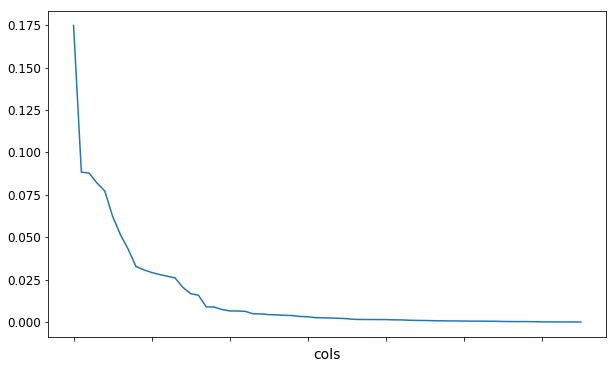

In [20]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

(*this should be displaying the column names on x-axis..*)

> In nearly every dataset you use in real life, this is what your feature importance is going to look like. There's a handful of columns you care about.

We can plot this as a barplot:

In [21]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

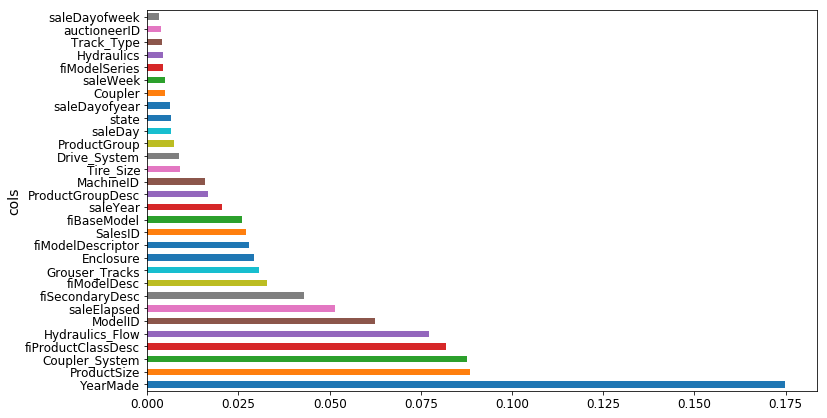

In [22]:
plot_fi(fi[:30]);

> Before we worry about how to calculate it – much more important is to know what to do with it. The most important thing to do with it is to now sit down with your client or data-dictionary (w/e your information source is) and ask them about the data. Ie: "what is `YearMade`?"

Find out everything you can about `YearMade`, `Coupler_System`, and `ProductSize`, and their relationships to price, because they are what matter.

> What'll often happen in real-world projects is you'll sit with the client and you'll say "turns out the Coupler System is the 2nd most important thing", and they might say "that makes no sense" That doesn't mean there's a problem w/ your model. It means there's a problem w/ their understanding of the data they gave you.

**Data Leakage**: there's information in the dataset you're modeling with which the client wouldn't've had in real-life at the point in time they're making a decision. 

> A lot of the key insights you'll find with feature importance are Data Leakage problems. You'll often find signs of co-linearity. (ie: `Coupler_System` is a proxy for a type of ind.eqpmt. that uses that feature).

Now let's keep the features with an importance greater than `0.005`. Our RF looking at all features got a validation R2 score of 0.89.

In [23]:
to_keep = fi[fi.imp > 0.005].cols; len(to_keep)

23

In [24]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [25]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20718513027092908, 0.2455197479433483, 0.910287699881376, 0.8923483147060356, 0.8940241362481987]


The R2 score basically didn't change – in fact removing the redundant columns actually made it a little better.

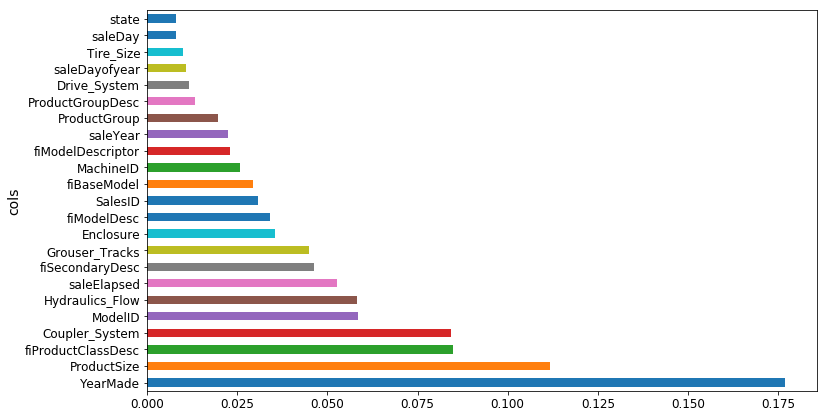

In [26]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

> When you remove redundant columns, you're also removing sources of colinearity – ie: 2 cols that might be related to each other. Colinearity won't make your RF less predictive – but if 2 cols are related, and one of them is a strong driver of the dependant variable, then what happens is the importance becomes split between them. By removing those cols w/ v.little impact, it makes feature importance a lot clearer.

> [Lecture 3 – 1:17:19](https://youtu.be/YSFG_W8JxBo?t=4639) Feature Importance is a technique that works for any kind of Machine Learning model.

Feature Importances are calculated by shuffling each column and measuring its affect on the model's score (running predictions again).

---
Lecture 4 RF Interpretation start.


More on RF Feature Importance -vs- Logistic Regression Coefficients.

[Lecture 4 – 38:40](https://youtu.be/0v93qHDqq_g?t=2320)

> You're much more often going to see people talk about Logistic Regression coefficients than you are to see them talk about Random Forest variable importance – and every time you see that happen you should be v.v.very skeptical.

## 3.1 One-Hot Encoding

[Lecture 4 – 40:37](https://youtu.be/0v93qHDqq_g?t=2437)

with `max_n_cats`, any category with `< max_n_cats` levels will be turned into a 1-hot encoded bunch of columns.

In [27]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20730757604107286, 0.25476890562005594, 0.9101816291640084, 0.8840846857167944, 0.8924669137249612]


[Lecture 4 – 47:14](https://youtu.be/0v93qHDqq_g?t=2834)

In this case the validation set RMSE & R2 got a little worse. This isn't always the case, and depends on the dataset: if the dataset has single columns which tend to be important or not.

In this case 1-hot encoding didn't make our model more predictive. But it did create different features. `proc_df` places the "`variablename`+`_`+`levelname`"

Whereas before "Enclosure" was only somewhat important, when we 1-hot encode it, "Enclosure_EROPS w AC" becomes the most important feature.

> For at least the purpose of interpreting your model, you should always try 1-hot encoding quite a few of your variables – 6 or 7 are often good.

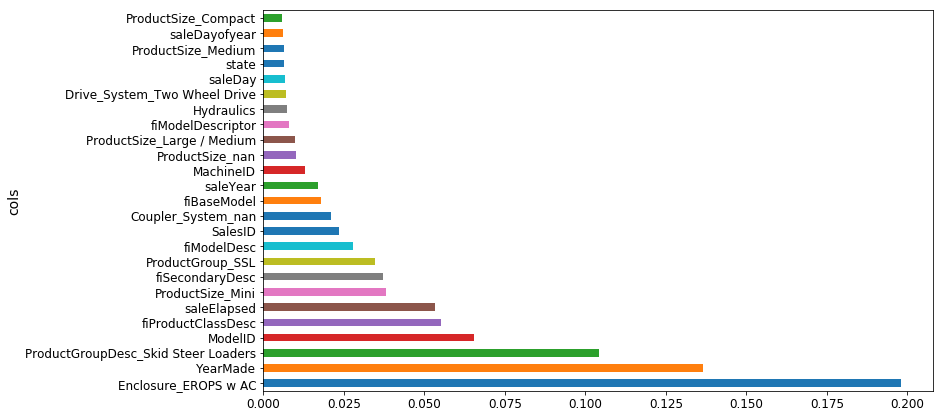

In [28]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

The number of levels in a category is its **cardinality**. `proc_df` checks the cardinality against `max_n_cats` and 1-hot encodes it if it's less.

The original variable is not kept when it's 1-hot encoded.

If you have an ordinal variable (0,1,2 for Hi, Med, Low), `proc_df` will destroy it's ordering if it's affected by `max_n_cats`. Convert it to numerical ahead of time via `df.CatName = df.CatName.cat.codes`. This will cause the `numericalize` within `proc_df` to skip over it.

## 4. Removing redundant features

[Lecture 4 – 54:50](https://youtu.be/0v93qHDqq_g?t=3290)

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundant features.

One way to do this is do use a dendrogram – a type of hierarchical clustering.

> In hierarchical (aka aglomorative) clustering, we look at every pair of objects and ask which 2 are the closest – and replace them with the midpoint (average) of the two.

In [29]:
from scipy.cluster import hierarchy as hc

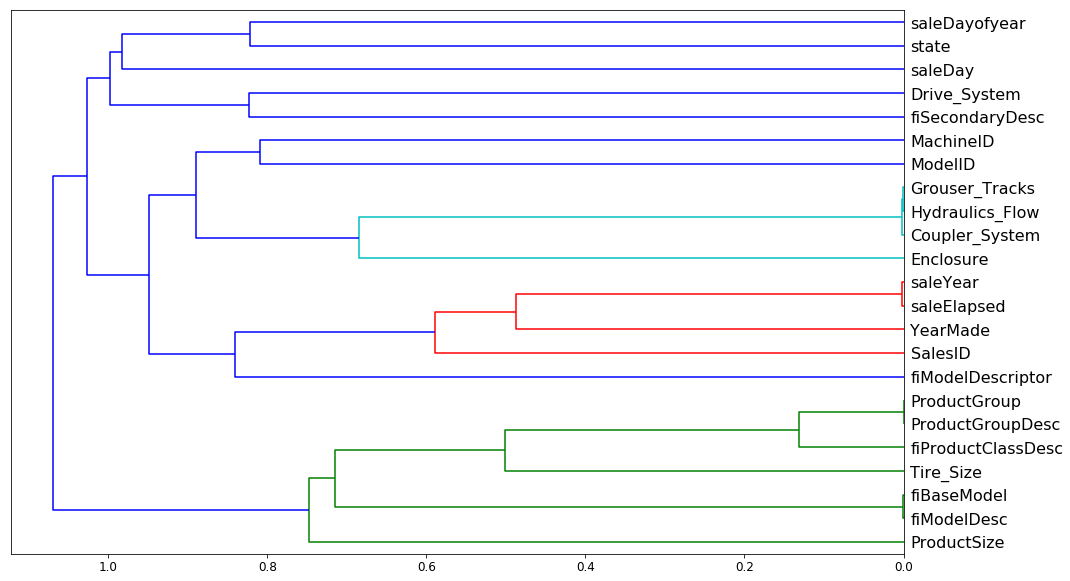

In [30]:
# create dendogram
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1 - corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

[Lecture 4 – 57:40](https://youtu.be/0v93qHDqq_g?t=3470) The horizontal axis is similarity. So, saleYear and saleElapsed are *very* similar. They've been combined by the hier.clustering algo and are v.similar.

Correlation is almost the same as the R2, except it's between 2 variables, and not between a variable and its prediction. Here the Spearman's R was used as the correlation metric (most common type).

Rank-correlation: replace each point with its rank on the x & y axis (turns data into a straight line).

> I want to find the columns that are similar in a way that the Random Forest would find them similar – RF's don't care about linearity, only ordering, so a rank-correlation is the 'right way' to think about it. 

It also has to be monotonic (parabolas won't work).



Let's try removing some of these related features to see if the model can be simplified without impacting accuracy.

In [31]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline:

In [32]:
get_oob(df_keep)

0.8900672314366508

We're going to try removing each of the most correlated variables one at a time and see which we can remove without worsening the OOB score.

In [33]:
for c in ('fiModelDesc', 'fiBaseModel', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow', 'saleElapsed', 'saleYear', ):
    print(c, get_oob(df_keep.drop(c, axis=1)))

fiModelDesc 0.8880537102299333
fiBaseModel 0.8901670877768342
Coupler_System 0.8901832888201284
Grouser_Tracks 0.890431087663299
Hydraulics_Flow 0.8907072210425535
saleElapsed 0.8878246402691617
saleYear 0.8890321447143599


What if we try one from each group for removal:

In [36]:
to_drop = ['fiBaseModel', 'Grouser_Tracks', 'saleYear']
get_oob(df_keep.drop(to_drop, axis=1))

0.8887697149686028

Looking good – let's use this dataframe from here. We'll save the list of columns so we can resuse it later.

In [37]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [38]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [39]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [40]:
reset_rf_samples() # use full dataset & bootstrapped samples

In [41]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12534213461044671, 0.22764123755915913, 0.9671656064536831, 0.9074556626842947, 0.9083576950520804]


We're getting a good score (better than before) with a smaller and simpler model now.

## 5. Partial Dependence

[Lecture 4 – 1:07:16](https://youtu.be/0v93qHDqq_g?t=4036)

Now we're at the point where we want to really try to understand the data better by taking advantage of the model. We'll use something called **Partial Dependence**. V.few people know about this powerful technique.

> What we're going to do is find out for the features that are important, how they relate to the dependent variable.

In [42]:
from pdpbox import pdp
from plotnine import *

In [43]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [47]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

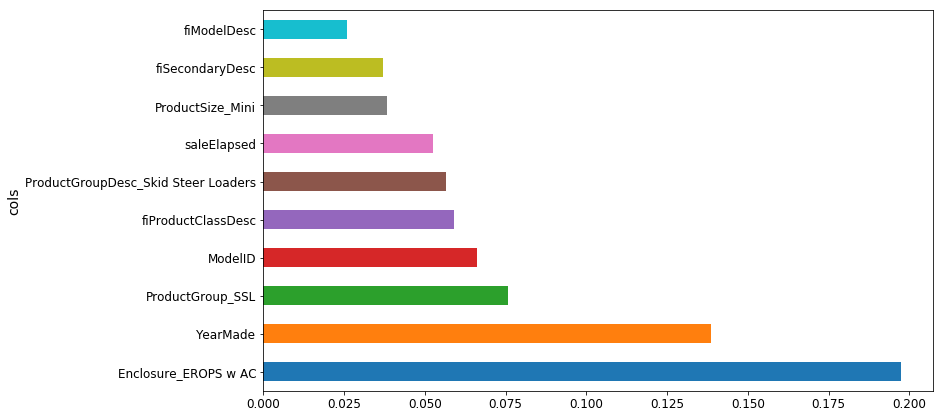

In [48]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

YearMade is the 2nd most important variable. We'd expect it to come together with saleElapsed to tell some info about how old the product was when it was sold.

We can plot them to see how they relate to each other:

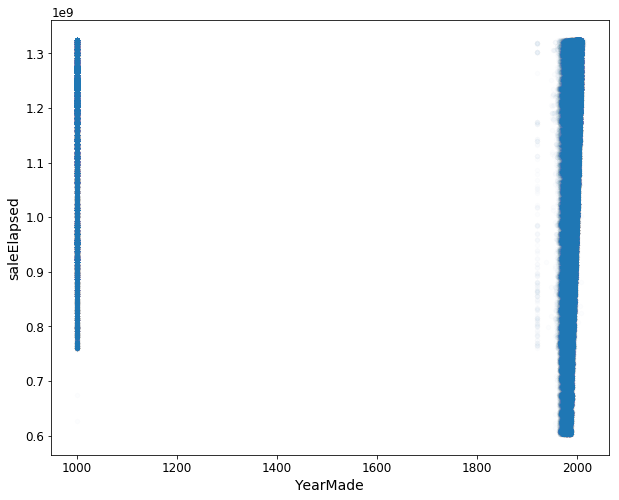

In [50]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

It's highly unlikely that tractors were made in the year 1000 ... so we can remove those.

In [56]:
x_all = get_sample(df_raw[df_raw.YearMade > 1930], 500) # grab 500 pts

[Lecture 4 – 1:09:58](https://youtu.be/0v93qHDqq_g?t=4198) the `ggplot` library uses it's R syntax.

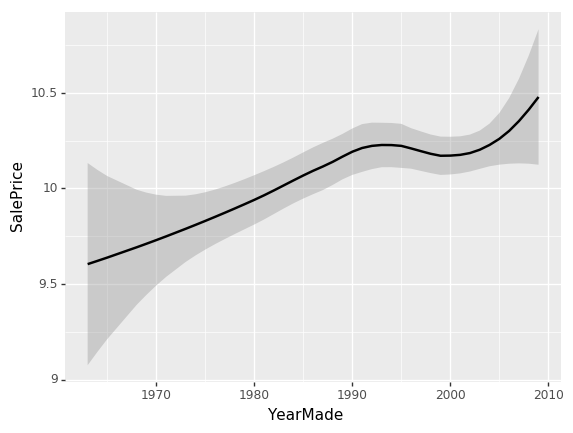

<ggplot: (-9223372036539678583)>

In [57]:
ggplot(x_all, aes('YearMade', 'SalePrice')) + stat_smooth(se=True, method='loess')

`loess` -- locallly-weighted regression (like doing lots of little linear regressions) –– *(JHoward uses this for univariate plots)*

> What we want to do is say what's the relationship between salePrice and YearMade – all other things being equal.

We do this with a **Partial Dependence Plot**:

In [58]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [59]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

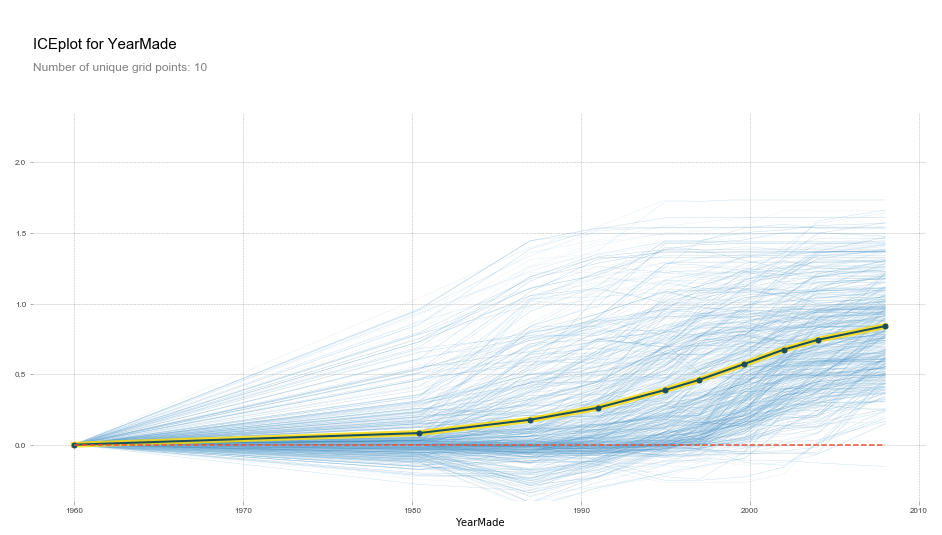

In [60]:
plot_pdp('YearMade')

[Lecture 4 – 1:15:07](https://youtu.be/0v93qHDqq_g?t=4507)

> We've got our sample of 500 datapoints. We're going to take each one of those 500 randomly chosen auctions and make a dataset out of it. 

Instead of shuffling a chosen column for feature importance, we're going to set the entire column to a single value, run that dataset pre-fit RF model seeing what the predictions become, and do so for each value for the chosen column in our dataset.

> Random shuffling the column tells us how accurate it is when you don't use that column anymore, replacing the whole column with a constant *(say, 1961 for YearMade)* estimates for us how much we would've sold that product for – in that auction, on that day, in that place, etc – **if** that product had been made in 1961.

> So we basically then take the average of all of the sale prices that we calculate from that Random Forest.

Each light-blue line is a row in our dataset. The y-axis is dependant-variable (zero-indexed to the 1st value in our chosen column: so 1900s prediction becomes 0), and x-axis is the values of our chosen independant variable (YearMade).

> This Partial Dependence Plot concept is something which uses a Random Forest to get us a clearer interpretation of what's going on in our data.

Steps:

1. look at **feature importance** to tell us what to care about

2. use the **partial dependence plot** to tell us what's going on, on average.

We can also use clusters with pdp.

> `clusters` uses Cluster Analysis to look at each one of the 500 rows and say "do some of those 500 rows kind of move in the same way"

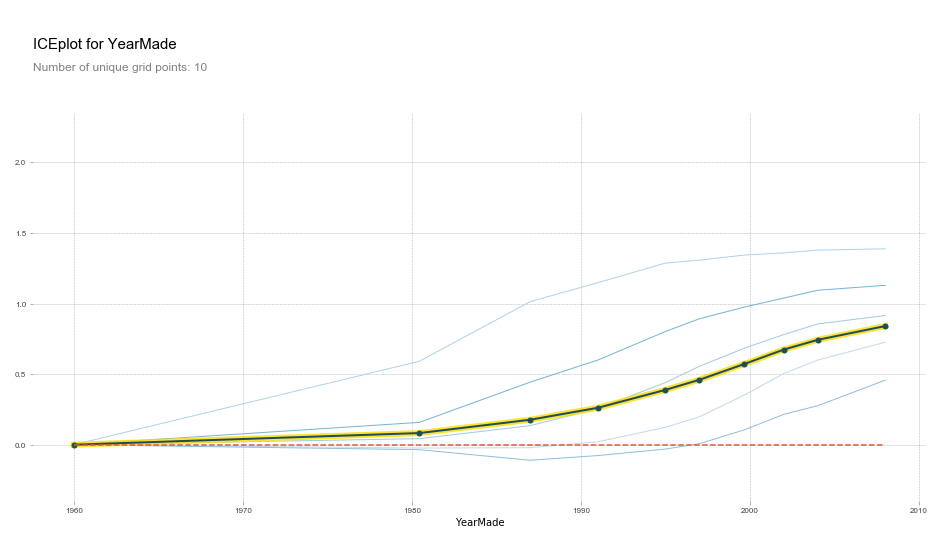

In [62]:
plot_pdp('YearMade', clusters=5)

Here's the result of the Cluster Analysis. We still see the same average, but we also see the 5 most common patterns/shapes in the data.

---

[Lecture 4 – 1:27:35](https://youtu.be/0v93qHDqq_g?t=5255)

You can do the same thing in a PDP-Interaction Plot. In this example: how do saleElapsed & YearMade *together* impact price?

y-axis: zero-indexed Log(price); (last plot: saleElapsed -vs- YearMade, w/ Log(price) color bar.

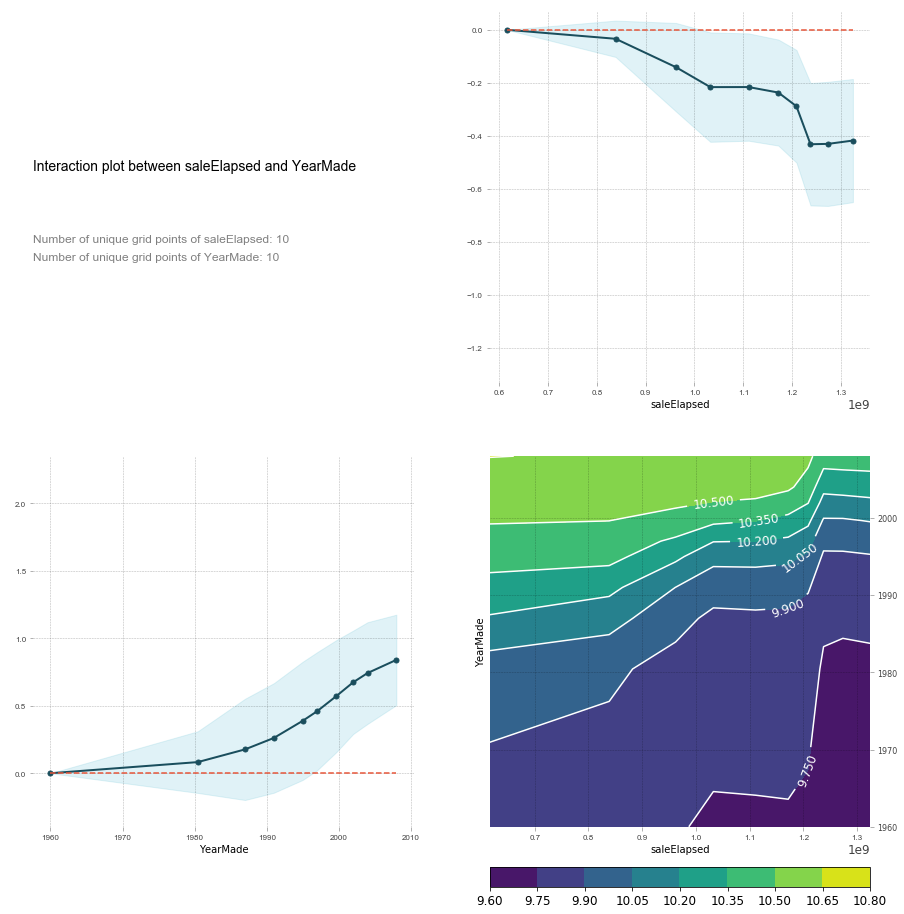

In [63]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

If you have 1-hot encoded variables, you can pass an array of them to `plot_pdp` and it'll treat them as categories.

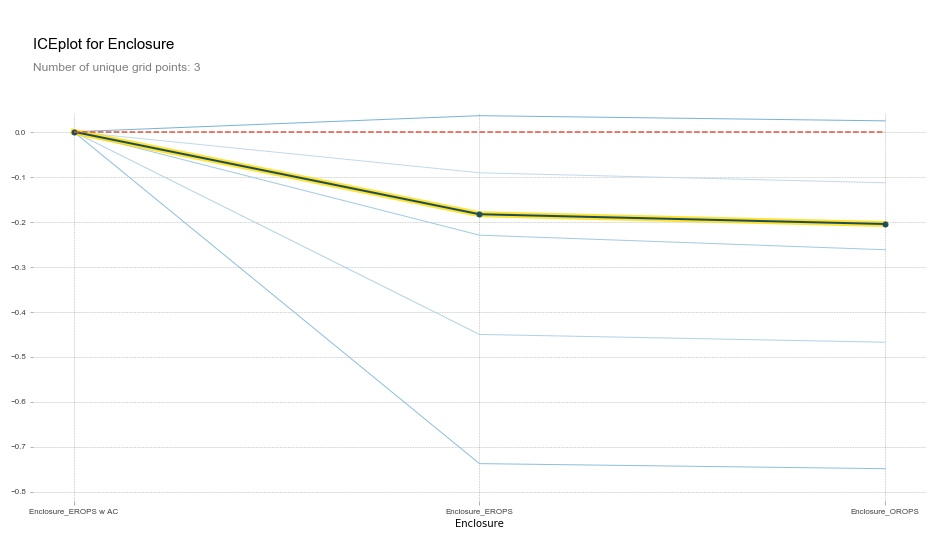

In [73]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

Enclosure_EROPS w AC are on average more expensive than Enclosure_EROPS which are on.avg slightly more expensive than Enclosure_OROPS.

[Lecture 4 – 1:31:24](https://youtu.be/0v93qHDqq_g?t=5484)

Based on all these interactions: let's check out setting everything made before 1950 to 1950 (there seems to be missing dates set to 1000 or 1900), and create an 'age' category. Run an RF on that and let's see how important `age` becomes in the sale of construction equipment.

In [74]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

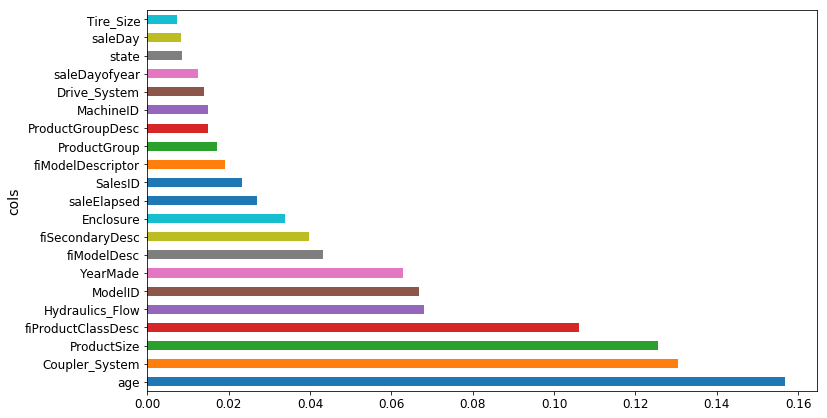

In [75]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

## 6. Tree Interpreter

[Lecture 4 – 1:32:30](https://youtu.be/0v93qHDqq_g?t=5550)

Tree Interpretation may be unimportant for Kaggle competitions but it is *vitally* important for real-world applications.

> Tree Interpreter allows us to take a particular row, (in this case row 0), let's you call `ti.predict` passing in your RF and the row (a particular auction or customer's information) and it'll display 3 things:

> 1. The RF's prediction
> 2. The Bias (avg. sale price across whole original dataset)
> 3. The Contributions

To find out why/how we arrive at a specific decision in a Random Forest, we can simply trace the leaf node prediction back through to the root of the tree. `contributions` shows each split point and value from root to leaf that led the RF to make a specific prediction.

In [77]:
from treeinterpreter import treeinterpreter as ti

In [78]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [79]:
row = X_valid.values[None, 0]; row

array([[      1999,          5,          0,         17,          0,        665, 1284595200,          0,
              3232,          1,          0,    4364751,          4,    2300944,          0,          0,
                 4,         16,         35,        259,         11]])

In [80]:
prediction, bias, contributions = ti.predict(m, row)

In [81]:
prediction[0], bias[0]

(9.306800797695304, 10.105414209021683)

In [82]:
idxs = np.argsort(contributions[0])

In [83]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.531897800356864),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.12777875705636715),
 ('age', 11, -0.1230352578754624),
 ('fiModelDesc', 'KX1212', -0.06429695750820139),
 ('fiSecondaryDesc', nan, -0.05472354042099488),
 ('Enclosure', 'EROPS', -0.043426017361440784),
 ('fiModelDescriptor', nan, -0.03343716157360368),
 ('saleElapsed', 1284595200, -0.0234380393919567),
 ('Tire_Size', nan, -0.016596968861341342),
 ('SalesID', 4364751, -0.015071057901257578),
 ('saleDayofyear', 259, -0.0134373918878953),
 ('MachineID', 2300944, -0.00808281735968901),
 ('saleDay', 16, 0.002627244531604944),
 ('ProductGroup', 'TEX', 0.006643776061455897),
 ('state', 'Ohio', 0.006759068526634993),
 ('Drive_System', nan, 0.008547643551969885),
 ('ProductGroupDesc', 'Track Excavators', 0.013558388800812926),
 ('Hydraulics_Flow', nan, 0.03156173744405044),
 ('YearMade', 1999, 0.05783227736847527),
 ('Coupler_System', nan, 0.06341225705818969),
 ('

In [84]:
contributions[0].sum()

-0.7986134113263783

## 7. Extrapolation

Lecture 5

**self note: comeback to this later and fill in notes**

In [85]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [86]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9999925210345902

In [87]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
11,SalesID,0.786710
6,saleElapsed,0.153094
13,MachineID,0.049669
5,ModelID,0.002298
0,YearMade,0.001966
19,saleDayofyear,0.001812
8,fiModelDesc,0.001183
9,Enclosure,0.001179
7,fiSecondaryDesc,0.000608
4,Hydraulics_Flow,0.000426


In [88]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [89]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [90]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


In [91]:
x.drop(feats, axis=1, inplace=True)

In [92]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9782885634153942

In [93]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
17,age,0.233065
0,YearMade,0.188074
16,saleDayofyear,0.162140
5,ModelID,0.080256
7,fiModelDesc,0.065816
14,saleDay,0.064389
15,state,0.058693
3,fiProductClassDesc,0.034648
6,fiSecondaryDesc,0.024488
8,Enclosure,0.020663


In [94]:
set_rf_samples(50000)

In [98]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [99]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20732218508844377, 0.24541989109033346, 0.9101689696453006, 0.8924358642620684, 0.8938017012211197]


In [100]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.20896872710860465, 0.2457949267740947, 0.9087364368447693, 0.8921068671960654, 0.8924951613415502]
saleElapsed
[0.2140015452301819, 0.25334212893002017, 0.9042875034196795, 0.8853793662139942, 0.8871234744679918]
MachineID
[0.20675807763153825, 0.24531975639354217, 0.9106571510098291, 0.8925236216539543, 0.894903006839451]
age
[0.20846663377542413, 0.24760162915675493, 0.9091744715454211, 0.8905149124980403, 0.8926126826684936]
YearMade
[0.2086129584339771, 0.2511086069391198, 0.9090469242407012, 0.8873915005248926, 0.8924032010346019]
saleDayofyear
[0.20832658795791745, 0.24376901262286063, 0.9092964619345454, 0.8938781113620977, 0.8932243397624751]


In [101]:
reset_rf_samples()

In [102]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.13800246004306055, 0.21698920627218976, 0.9601976712410503, 0.9159138948727017, 0.9091438213957634]


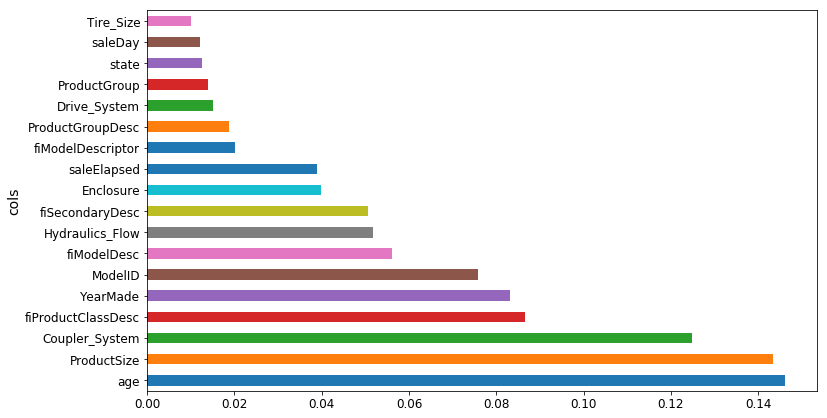

In [103]:
plot_fi(rf_feat_importance(m, X_train));

In [104]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

## Our Final Model:

In [105]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 5min 6s, sys: 11.4 s, total: 5min 17s
Wall time: 1min 40s
[0.08060201550993717, 0.2107441175127788, 0.9864222868391533, 0.9206843484697286, 0.9147146645659682]
